# Data Visualization

## Amazon Sales Analysis (2019)

We have obtained Amazon Sales Data for each month in 2019. It's located in `data/`

Up to now, we've only dealt with aggregated data (in one file/location), but in this case, we have multiple csv files that we need to draw from.

Use a loop to conveniently store all of the data in one place.

In [1]:
# required imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import collections
from collections import Counter
import datetime

# the path
path = '../data/Sales_Data'

#Jaunuray = pd.read_csv('./data/Sales_January_2019.csv')

files = [file for file in os.listdir(path)]

for file in files:
    df = pd.read_csv('./data/Sales_Data'+file)
    all_data = pd.concat([all_data, df])
    
#all_data.to_csv('all_data.csv', index=False)

### Exercise 1: Merge data from each month into one CSV (step-by-step)

In [2]:

Jaunuray = pd.read_csv('../data/Sales_January_2019.csv')
February = pd.read_csv('../data/Sales_February_2019.csv')
March = pd.read_csv('../data/Sales_March_2019.csv')
April = pd.read_csv('../data/Sales_April_2019.csv')
May = pd.read_csv('../data/Sales_May_2019.csv')
June = pd.read_csv('../data/Sales_June_2019.csv')
July = pd.read_csv('../data/Sales_July_2019.csv')
August = pd.read_csv('../data/Sales_August_2019.csv')
October = pd.read_csv('../data/Sales_October_2019.csv')
September = pd.read_csv('../data/Sales_September_2019.csv')
November = pd.read_csv('../data/Sales_November_2019.csv')
December = pd.read_csv('../data/Sales_December_2019.csv')



In [3]:
# 1.2 concat data from all files into one file `data/all_data.csv`
months = [ Jaunuray, February, April, May, June, July, August, October, September, November, December]
df = pd.concat([ 
    Jaunuray, February, April, May,
    June, July, August, October, September,
    November, December]).reset_index(drop=True)


df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"
...,...,...,...,...,...,...
171619,319666,Lightning Charging Cable,1,14.95,12/11/19 20:58,"14 Madison St, San Francisco, CA 94016"
171620,319667,AA Batteries (4-pack),2,3.84,12/01/19 12:01,"549 Willow St, Los Angeles, CA 90001"
171621,319668,Vareebadd Phone,1,400,12/09/19 06:43,"273 Wilson St, Seattle, WA 98101"
171622,319669,Wired Headphones,1,11.99,12/03/19 10:39,"778 River St, Dallas, TX 75001"


In [4]:
# 1.3 read the updated dataframe
df.head()
df.count()

Order ID            171116
Product             171116
Quantity Ordered    171116
Price Each          171116
Order Date          171116
Purchase Address    171116
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171624 entries, 0 to 171623
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          171116 non-null  object
 1   Product           171116 non-null  object
 2   Quantity Ordered  171116 non-null  object
 3   Price Each        171116 non-null  object
 4   Order Date        171116 non-null  object
 5   Purchase Address  171116 non-null  object
dtypes: object(6)
memory usage: 7.9+ MB


### Exercise 2: Clean up the data!

In [6]:
# 2.1 Drop rows of NAN
df.isna().sum()

Order ID            508
Product             508
Quantity Ordered    508
Price Each          508
Order Date          508
Purchase Address    508
dtype: int64

In [7]:
df = df.dropna()
df.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [8]:
df[df['Order Date'].str[0:2]=='Or'].count()

Order ID            320
Product             320
Quantity Ordered    320
Price Each          320
Order Date          320
Purchase Address    320
dtype: int64

In [9]:
# 2.2 Get rid of text in order date column
df = df[df['Order Date'].str[0:2]!='Or']
df['date'] = pd.to_datetime(df['Order Date'])
df['date']

0        2019-01-22 21:25:00
1        2019-01-28 14:15:00
2        2019-01-17 13:33:00
3        2019-01-05 20:33:00
4        2019-01-25 11:59:00
                 ...        
171619   2019-12-11 20:58:00
171620   2019-12-01 12:01:00
171621   2019-12-09 06:43:00
171622   2019-12-03 10:39:00
171623   2019-12-21 21:45:00
Name: date, Length: 170796, dtype: datetime64[ns]

In [10]:
# 2.3 Make columns correct type
df['Price Each'] = df['Price Each'].astype(float)
df['Quantity Ordered'] = df['Quantity Ordered'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170796 entries, 0 to 171623
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          170796 non-null  object        
 1   Product           170796 non-null  object        
 2   Quantity Ordered  170796 non-null  float64       
 3   Price Each        170796 non-null  float64       
 4   Order Date        170796 non-null  object        
 5   Purchase Address  170796 non-null  object        
 6   date              170796 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 10.4+ MB


### Exercise 3: Augment data with additional columns

In [11]:
# 3.1 Add month column
df['month'] = df['Order Date'].str[0:2].astype(int)
df['month']

0          1
1          1
2          1
3          1
4          1
          ..
171619    12
171620    12
171621    12
171622    12
171623    12
Name: month, Length: 170796, dtype: int32

In [12]:
df['day'] = df['Order Date'].str[3:5].astype(int)
df['day']

0         22
1         28
2         17
3          5
4         25
          ..
171619    11
171620     1
171621     9
171622     3
171623    21
Name: day, Length: 170796, dtype: int32

In [13]:
df = df.drop(['Order Date'], axis=1)

In [14]:
# 3.2 Add city column

df['city'] =df['Purchase Address'].apply(lambda row: row.split(',')[1:2])
df.head(3)

,Order ID,Product,Quantity Ordered,Price Each,Purchase Address,date,month,day,city
0,141234,iPhone,1.0,700.00,"944 Walnut St, Boston, MA 02215",2019-01-22 21:25:00,1,22,[ Boston]
1,141235,Lightning Charging Cable,1.0,14.95,"185 Maple St, Portland, OR 97035",2019-01-28 14:15:00,1,28,[ Portland]
2,141236,Wired Headphones,2.0,11.99,"538 Adams St, San Francisco, CA 94016",2019-01-17 13:33:00,1,17,[ San Francisco]


### Exercise 4: Data Exploration!

#### Question 4.1: What was the best month for sales? How much was earned that month? 

In [15]:
#having the total price for all orders
df['total price'] = df['Quantity Ordered'] * df['Price Each']
df.head(3)

,Order ID,Product,Quantity Ordered,Price Each,Purchase Address,date,month,day,city,total price
0,141234,iPhone,1.0,700.00,"944 Walnut St, Boston, MA 02215",2019-01-22 21:25:00,1,22,[ Boston],700.00
1,141235,Lightning Charging Cable,1.0,14.95,"185 Maple St, Portland, OR 97035",2019-01-28 14:15:00,1,28,[ Portland],14.95
2,141236,Wired Headphones,2.0,11.99,"538 Adams St, San Francisco, CA 94016",2019-01-17 13:33:00,1,17,[ San Francisco],23.98


In [16]:
# grouped on month denoting the highest quantity sold monthly
df_group_month = df.groupby('month').sum()
df_group_month.head(3)

,Quantity Ordered,Price Each,day,total price
month,,,,
1,10903.0,1811768.38,155814,1822256.73
2,13449.0,2188884.72,174408,2202022.42
3,18.0,3203.66,17,3207.50


In [17]:
best_month_sales= df_group_month['total price'].sort_values(ascending=False).head(3) 

best_month_sales

month
12    4.613443e+06
10    3.736727e+06
4     3.385500e+06
Name: total price, dtype: float64

In [18]:
max_sales_price = df[df['month']==12]['total price'].sum()
max_sales_price

4613443.339999999

#### Question 4.2: What city sold the most product?

In [19]:
# 4.2
best_sale_price_city = df.loc[df['Quantity Ordered'].max()][['city', 'total price']].head(1);  

best_sale_price_city

city    [ San Francisco]
Name: 9, dtype: object

In [20]:
# 4.2 continued
best_sale_quantity_city = df.loc[df['total price'].max()][['city', 'total price']].head(1)
best_sale_quantity_city

city    [ San Francisco]
Name: 3400, dtype: object

#### Question 4.3: What time should we display advertisements to maximize likelihood of customer's buying product?

In [21]:
# 4.3.1 Add hour column
df['hour'] = df['date'].dt.hour

In [22]:
# 4.3.2 Results
df.head(3)


,Order ID,Product,Quantity Ordered,Price Each,Purchase Address,date,month,day,city,total price,hour
0,141234,iPhone,1.0,700.00,"944 Walnut St, Boston, MA 02215",2019-01-22 21:25:00,1,22,[ Boston],700.00,21
1,141235,Lightning Charging Cable,1.0,14.95,"185 Maple St, Portland, OR 97035",2019-01-28 14:15:00,1,28,[ Portland],14.95,14
2,141236,Wired Headphones,2.0,11.99,"538 Adams St, San Francisco, CA 94016",2019-01-17 13:33:00,1,17,[ San Francisco],23.98,13


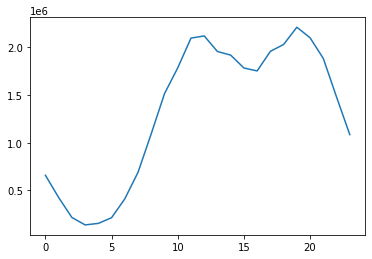

In [23]:
adver_tim = df.groupby('hour').sum().reset_index()#['total price'].sort_values(ascending=False)
y=adver_tim['total price']
x=adver_tim['hour'].astype(int)
plt.plot(x, y)

Regarding the figure plotted above, between around 10.00 am. to 20.00

is the rush hour for selling the products.so it would be the best time for advertisung. 

Moreover, the maximum liklihood would ba happened around "10.00-11.00" am and "19.00-20.00".

#### Question 4.4: What products are most often sold together?

In [24]:
dfd = df[df['Order ID'].duplicated(keep=False)]
dfd['grouped'] = dfd.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
dfd = dfd[['Order ID', 'grouped']].drop_duplicates()
dfd.head(5)

<ipython-input-24-00ed181efe4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfd['grouped'] = dfd.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))


,Order ID,grouped
41,141275,"USB-C Charging Cable,Wired Headphones"
57,141290,"Apple Airpods Headphones,AA Batteries (4-pack)"
133,141365,"Vareebadd Phone,Wired Headphones"
153,141384,"Google Phone,USB-C Charging Cable"
220,141450,"Google Phone,Bose SoundSport Headphones"


In [ ]:
dfd[dfd.duplicated('Order ID', keep=False)] 

count = Counter() #making object from Counter class
for row in dfd:  # combine and count how many is there from one combination to see haw often was sold.
    count.update(Counter(combinations(df['Product'], 2)))
    
for key, value in count.most_common(2): #give us top10 records
    print(key, value)
    
#it takes time to show the result being hard for my system, that's why there is no result!!!

In [ ]:
# https://stackoverflow.com/questions/43348194/pandas-select-rows-if-id-appear-several-time


# Referenced: https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby


In [ ]:
# Referenced: https://stackoverflow.com/questions/52195887/counting-unique-pairs-of-numbers-into-a-python-dictionary


## Exercise 5: Most Popular Product?

What product sold the most? Why do you think it sold the most?

In [ ]:
# exercise 5

#how many each product was ordered.(top5)
df.groupby('Product').sum()['Quantity Ordered'].sort_values(ascending=False).head(5)

In [ ]:

sold_most = df.groupby('Product')

quantity_ordered = sold_most.sum()['Quantity Ordered']

products = [product for product, dfd in sold_most] #products ordered by grouped index


In [ ]:
# visualized the result mentioned above

plt.bar(products, quantity_ordered)
plt.xlabel('products')
plt.ylabel('quantity ordered')
plt.xticks(rotation='vertical')

plt.show

exercise 5 continued


 Referenced: https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib


## Note

This activity was taken from https://github.com/KeithGalli/Pandas-Data-Science-Tasks. We modified to be exercises rather than a code-along tutorial. 

Once you have completed all, or as much as you can, of the activity, feel free to watch [Keith Galli's accompanying video](https://www.youtube.com/watch?v=eMOA1pPVUc4).